### JHU-CROWD++ Processing to PyTorch Dataset

Dataset Source: http://www.crowd-counting.com/

Note: in this ground-truth files, there appear to be points for the heads that are not inside the image. For the purposes of this project, such points with coordinates exceeding the images' borders will have their coordinates clipped to fit in the image. This ensures we do not lose any datapoints while running our code.

In [ ]:
!pip install imbalanced-learn
!pip install graphviz
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-bmastqp0
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-bmastqp0
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184468 sha256=9e043c49c8fbf33c8bb34df6157506aa3b28112c748262a08625c24f0455d238
  Stored in directory: /tmp/pip-ephem-wheel-cache-ze3829_r/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [ ]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import IPython
import IPython.display

import warnings

warnings.filterwarnings("ignore")

import os
import zipfile

import PIL
from PIL import Image

import cv2

import numbers
import collections

In [ ]:
# Load the data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/jhu_crowd_v2.0.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/jhu_crowd')

In [ ]:
base_dir = '/content/jhu_crowd/jhu_crowd_v2.0'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
os.listdir(train_dir)

['image_labels.txt', 'gt', 'images']

In [ ]:
# Custom transforms implementations credited to
# https://github.com/mlagunas/pytorch-nptransforms/blob/master/np_transforms.py

In [ ]:
def _is_numpy_image(img):
    return isinstance(img, np.ndarray)

In [ ]:
def crop(pic, i, j, h, w):
    if not _is_numpy_image(pic):
        raise TypeError('img should be Numpy Image. Got {}'.format(type(pic)))

    return pic[i:i + h, j:j + w, :]

In [ ]:
class RandomCrop(object):
    """
    Performs a random crop in a given numpy array using only the first two dimensions (width and height)
    """

    def __init__(self, size, ):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    @staticmethod
    def get_params(pic, output_size):

        # read dimensions (width, height, channels)
        w, h, c = pic.shape

        # read crop size
        th, tw = output_size

        # get crop indexes
        i = random.randint(0, w - tw)
        j = random.randint(0, h - th)

        return i, j, th, tw

    def __call__(self, pic):
        """
        :param input: numpy array
        :return: numpy array croped using self.size
        """

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        # if image has only 2 channels make it three channel
        if len(pic.shape) != 3:
            pic = pic.reshape(pic.shape[0], pic.shape[1], -1)

        # get crop params: starting pixels and size of the crop
        i, j, th, tw = self.get_params(pic, self.size)

        # perform cropping and return the new image
        return pic[i:i + th, j:j + tw, :]

In [ ]:
class Normalize_01(object):
    """
    Normalize the values of a numpy array between 0-1
    """

    def __init__(self, min=None, max=None):
        """
        :param min: minimum value, by default None. Useful to normalize 0-1 globally
               max: maximum value, by default None. Useful to normalize 0-1 globally
        """
        self.min = min
        self.max = max

    def __call__(self, pic):
        """
        :param pic: numpy array
        :return: same array with its values normalized between 0-1
        """
        min = self.min if self.min is not None else np.min(pic)
        max = self.max if self.max is not None else np.max(pic)

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))
        pic = (pic - min) / (max - min)
        return pic

In [ ]:
class ToTensor(object):
    """
    Convert a ``numpy.ndarray`` to tensor.
    """

    def __call__(self, pic):
        """
        Args:
            converts pic (numpy array) to Tensor
        Returns:
            Tensor: Converted image.
        """

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        if len(pic.shape) == 1: return torch.FloatTensor(pic.copy())

        return torch.FloatTensor(pic.transpose((2, 0, 1)).copy())

In [ ]:
class Scale(object):
    """
    Rescale the given numpy image to a specified size.
    """

    def __init__(self, size, interpolation="bilinear"):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, pic):

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        if isinstance(self.size, int):
            # if size is specified with one dimension only get the second one keeping the
            # aspect-ratio

            # get the size of the original image
            w, h = pic.shape[:2]
            if (w <= h and w == self.size) or (h <= w and h == self.size):
                return pic

            # calculate the ouput size keeping the aspect-ratio
            if w < h:
                ow = self.size
                oh = int(self.size * h / w)
            else:
                oh = self.size
                ow = int(self.size * w / h)

            # create the output array
            img_out = np.zeros((ow, oh, pic.shape[2]))

            if len(pic.shape) == 3:
                # if 3D image, scale each channel individually
                for i in range(pic.shape[2]):
                    img_out[:, :, i] = np.array(Image.fromarray(pic[:, :, i]).resize((ow, oh)))
                return img_out
            else:
                # if 2D image, scale image
                return np.array(Image.fromarray(pic).resize((ow, oh)))
        else:
            # if size is specified with 2 dimensions apply the scale directly
            # create the output array

            if len(pic.shape) == 3:
                img_out = np.zeros((self.size[0], self.size[1], pic.shape[2]))

                # if 3D image, scale each channel individually
                for i in range(pic.shape[2]):
                    img_out[:, :, i] = np.array(Image.fromarray(pic[:, :, i]).resize(self.size))
                return img_out
            else:
                # if 2D image, scale image
                return np.array(Image.fromarray(pic).resize(self.size))

In [ ]:
# Dataset object for this data
class JHUCrowdDataset(Dataset):
    def __init__(self, gt_dir, img_dir, transform=None):
        self.gt_dir = gt_dir
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        # Debug: print gt file name (matches image file name)
        # print(sorted(os.listdir(self.gt_dir))[idx])
        gt_path = os.path.join(self.gt_dir, sorted(os.listdir(self.gt_dir))[idx])
        img_path = os.path.join(self.img_dir, sorted(os.listdir(self.img_dir))[idx])

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        labels = self.getCoords(gt_path, image.shape[0:2])

        if self.transform:
            image = self.transform(image)
            labels = self.transform(labels)
        return (image, labels)
    
    # Return an np array with all the heads' coordinates
    # Storing the ground truths in an array makes transforms easier
    def getCoords(self, gt_path, image_shape):
        faces = np.zeros(image_shape)
        with open(gt_path,'r') as data_file:
          for line in data_file:
              data = line.split()
              data_y = min(int(data[1]), faces.shape[0] - 1)
              data_x = min(int(data[0]), faces.shape[1] - 1)
              # if data_y > faces.shape[0]:
              #     #data_y = faces.shape[0]
              #     continue
              # elif data_x > faces.shape[1]:
              #     #data_x = faces.shape[1]
              #     continue
              faces[data_y, data_x] = 1
        return faces

In [ ]:
# Apply transforms
transformer = transforms.Compose([
    Scale(size=(512,512)),
    RandomCrop(size=(512,512)),
    Normalize_01(),
    ToTensor()
])

In [ ]:
# Get directories
train_gt_dir = os.path.join(train_dir, 'gt')
train_img_dir = os.path.join(train_dir, 'images')
val_gt_dir = os.path.join(val_dir, 'gt')
val_img_dir = os.path.join(val_dir, 'images')
test_gt_dir = os.path.join(test_dir, 'gt')
test_img_dir = os.path.join(test_dir, 'images')

In [ ]:
# Create datasets
train_data = JHUCrowdDataset(train_gt_dir, train_img_dir, transform=transformer)
val_data = JHUCrowdDataset(val_gt_dir, val_img_dir, transform=transformer)
test_data = JHUCrowdDataset(test_gt_dir, test_img_dir, transform=transformer)

In [ ]:
# Create subsets of agreed-upon sizes, comment to use the full dataset
train_subset = torch.utils.data.Subset(train_data, range(500))
val_subset = torch.utils.data.Subset(train_data, range(100))
test_subset = torch.utils.data.Subset(train_data, range(200))
type(train_subset)

torch.utils.data.dataset.Subset

In [ ]:
train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)

In [ ]:
# Run through a batch to confirm it loads properly
for i, data in enumerate(train_dataloader):
    print(data[0].shape)
    print(data[1].shape)
    break

torch.Size([64, 3, 512, 512])
torch.Size([64, 1, 512, 512])


torch.Size([3, 512, 512]) torch.Size([1, 512, 512])


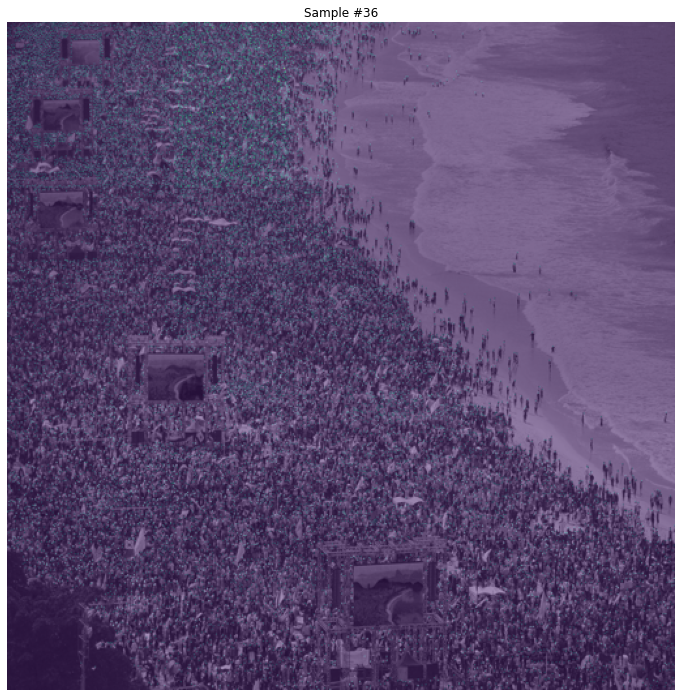

In [ ]:
# Visualize one of the images
fig = plt.figure(figsize=(10, 10))

# for i in range(len(train_dataset)):
i = 36
sample = train_data[i]

print(sample[0].shape, sample[1].shape)

ax = plt.subplot(1, 1, 1)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')

plt.imshow(sample[0][0,:,:], cmap='gray')
plt.imshow(sample[1][0,:,:], alpha=0.5)

In [ ]:
from torch import nn
from torchvision import models
import torchsummary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
# Implementing CG-DRCN model
# Source: http://www.crowd-counting.com/assets/img/jhucrowdv1_iccv19.pdf

class CGDRCN(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg16_model = models.vgg16(pretrained=True)
    self.C1 = list(self.vgg16_model.children())[0][0:4]
    self.C2 = list(self.vgg16_model.children())[0][5:10]
    self.C3 = list(self.vgg16_model.children())[0][10:17]
    self.C4 = list(self.vgg16_model.children())[0][17:24]
    self.C5 = list(self.vgg16_model.children())[0][24:]
    self.CB6 = nn.Sequential(
        nn.Conv2d(512, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 1, 3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.CB5 = nn.Sequential(
        nn.Conv2d(512, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 1, 3, stride=1, padding=1),
    )
    self.CB4 = nn.Sequential(
        nn.Conv2d(512, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 1, 3, stride=1, padding=1),
    )
    self.CB3 = nn.Sequential(
        nn.Conv2d(256, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 1, 3, stride=1, padding=1),
    )

    self.DR5 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=32, kernel_size=1)
    )
    self.DR4 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=32, kernel_size=1)
    )
    self.DR3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=32, kernel_size=1)
    )

    self.CEB5 = nn.Sequential(
        nn.Conv2d(33, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 1, 1, stride=1),
    )
    self.CEB4 = nn.Sequential(
        nn.Conv2d(33, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 1, 1, stride=1),
    )
    self.CEB3 = nn.Sequential(
        nn.Conv2d(33, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 1, 1, stride=1),
    )

    self.up = nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'bilinear')
    )
  def forward(self, x):
    #print(x.shape)
    F1 = self.C1(x)
    F2 = self.C2(F1)
    F3 = self.C3(F2)
    F4 = self.C4(F3)
    F5 = self.C5(F4)
    #print('F5', F5.shape)
    Yhat6 = self.CB6(F5)

    dimRed5 = self.DR5(F5)
    print(dimRed5.shape)
    R5 = self.CB5(F5)
    print(R5.shape)
    concat5 = torch.concat((dimRed5, R5), 1)
    CM5 = self.CEB5(concat5)
    Rhat5 = torch.mul(R5, CM5)

    dimRed4 = self.DR4(F4)
    #print(dimRed4.shape)
    R4 = self.CB4(F4)
    #print(R4.shape)
    concat4 = torch.concat((dimRed4, R4), 1)
    #print(concat4.shape)
    CM4 = self.CEB4(concat4)
    #print(CM4.shape)
    Rhat4 = torch.mul(R4, CM4)
    #print(Rhat4.shape)

    dimRed3 = self.DR3(F3)
    R3 = self.CB3(F3)
    concat3 = torch.concat((dimRed3, R3), 1)
    CM3 = self.CEB3(concat3)
    Rhat3 = torch.mul(R3, CM3)

    Yhat5 = Rhat5 + self.up(Yhat6)
    Yhat4 = Rhat4 + self.up(Yhat5)
    Yhat3 = Rhat3 + self.up(Yhat4)

    CMi = (CM3, CM4, CM5, Yhat6)
    Yi = (F3, F4, F5, Yhat6)
    Yhati = (Yhat3, Yhat4, Yhat5, Yhat6)

    return Yhat3, CMi, Yi, Yhati

In [ ]:
cgdrcn = CGDRCN()

In [ ]:
torchsummary.summary(cgdrcn, (3,512,512))

torch.Size([2, 32, 32, 32])
torch.Size([2, 1, 32, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
            Conv2d-2         [-1, 64, 512, 512]           1,792
              ReLU-3         [-1, 64, 512, 512]               0
              ReLU-4         [-1, 64, 512, 512]               0
            Conv2d-5         [-1, 64, 512, 512]          36,928
            Conv2d-6         [-1, 64, 512, 512]          36,928
              ReLU-7         [-1, 64, 512, 512]               0
              ReLU-8         [-1, 64, 512, 512]               0
            Conv2d-9        [-1, 128, 512, 512]          73,856
           Conv2d-10        [-1, 128, 512, 512]          73,856
             ReLU-11        [-1, 128, 512, 512]               0
             ReLU-12        [-1, 128, 512, 512]               0
           Conv2d-13        [-1, 128, 512, 512] 

In [ ]:
data = train_data[36]
image = torch.tensor(data[0], dtype=torch.float32)
print(image.shape, image.dtype)
print(data[1].shape)
out, CMi, Yi, Yhati = cgdrcn( torch.stack([image]) )

torch.Size([3, 512, 512]) torch.float32
torch.Size([1, 512, 512])
torch.Size([1, 32, 32, 32])
torch.Size([1, 1, 32, 32])


In [ ]:
out[0].shape

torch.Size([1, 128, 128])

In [ ]:
import seaborn as sns 
sns.set_theme()

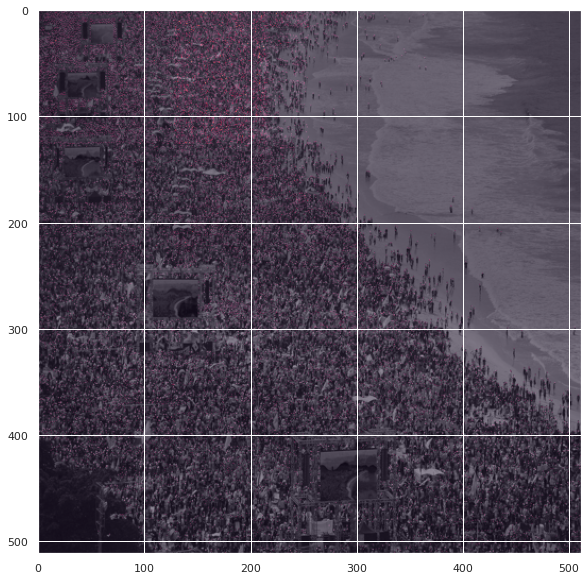

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(sample[0][0,:,:], cmap='gray')
plt.imshow(sample[1][0,:,:], alpha=0.5)

In [ ]:
sample[1][0,:,:].sum()

tensor(26398.0586)

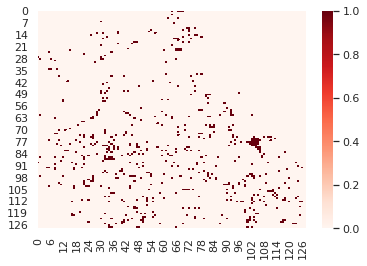

In [ ]:
imres = out[0][0].detach()
imresFix = transforms.Lambda(lambda x: torch.where(abs(x) > 0.07, 1.0, 0.0))(imres)
ax = sns.heatmap(imresFix.numpy(), cmap="Reds")

In [ ]:
imresFix.sum()

tensor(593.)

In [ ]:
import torch.nn.functional as nn_F

In [132]:
print(CMi[0].shape)

torch.Size([1, 1, 128, 128])


In [133]:
class CGDRCNLoss(nn.Module):
  def __init__(self, lambda_c):
    super().__init__()
    self.lambda_c = lambda_c
  def forward(self, CMi, Yi, Yhati):
    loss_d = 0
    for i in range(len(CMi)):
      real = torch.multiply(CMi[i], Yi[i])
      pred = torch.multiply(CMi[i], Yhati[i])
      loss_d += torch.linalg.norm((real - pred), ord = 2)
    
    loss_c = 0
    for i in range(len(CMi)):
      loss_c += torch.sum(torch.log(CMi[i]))

    loss_func = loss_d - self.lambda_c * loss_c
    return loss_func